### This notebook is suitable for model training on datasets after preprocessing (e.g. `clr-1`, `alr`) e.g. models, once trained, are dataset-specific and cannot be evaluated on different datasets.

In [1]:
import os
import sys
import joblib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pickle

from pathlib import Path

In [2]:
MODULE_PATH = os.path.abspath('/storage/pszczerbiak/microbiome_interactions_project/')  # TODO load from CONFIG file
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)

In [3]:
from utils.transformers import inverse_through_timesteps_wrapper
from utils.train_test import series_to_supervised, split_reframed, prepare_sequential_data, prepare_supervised_data
from models.baseline import sequential_mlp, supervised_mlp, SupervisedMLP, SequentialMLP
from models.baseline_with_diff import SupervisedDiffMLP, SequentialDiffMLP
from models.baseline_with_attention import SupervisedAttentionMLP, supervised_attention_mlp
from utils.evaluate import calculate_measures, plot_series

## Load data

#### Note 1: we're using two scalers in general since the input and output may be different e.g. `alr -> clr`
#### Note 2: we don't work on counts anymore so scaler details are not important

In [4]:
in_sname = 'alr-1'
out_sname = 'clr-1'
snames = [in_sname, out_sname]

In [5]:
dname = 'donorA'  # dataset name

# PREPROCESSING
filtername = 'filtered-0.9'
pseudovalue = 'pseudo-0.01'
DATA_PATH = Path("/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets_no_rarefaction_preprocessed/")  # TODO load from CONFIG file
datasets = {snames[0]: pd.read_csv(DATA_PATH / "filtered_transformed/" /\
                                   f"{dname}_{filtername}_{pseudovalue}_{snames[0]}.csv", index_col=0),
            snames[1]: pd.read_csv(DATA_PATH / "filtered_transformed/" /\
                                   f"{dname}_{filtername}_{pseudovalue}_{snames[1]}.csv", index_col=0)}
dataset_original = pd.read_csv(DATA_PATH / "filtered" / f"{dname}_{filtername}.csv", index_col=0)

In [6]:
dataset_original.shape

(362, 278)

### Remove ALR bacterium

In [7]:
if 'alr-1' in snames:
    ALR_bacterium =  pickle.load(open(DATA_PATH  / 'ALR_bacteria.pkl', 'rb'))[dname]
    dataset_original.drop(columns=[ALR_bacterium], inplace=True)
    datasets[in_sname].drop(columns=[ALR_bacterium], inplace=True)
    if in_sname != out_sname:
        datasets[out_sname].drop(columns=[ALR_bacterium], inplace=True)
    print(dataset_original.shape)

(362, 277)


In [8]:
datasets[in_sname].shape, datasets[out_sname].shape, dataset_original.shape

((362, 277), (362, 277), (362, 277))

## Plot data

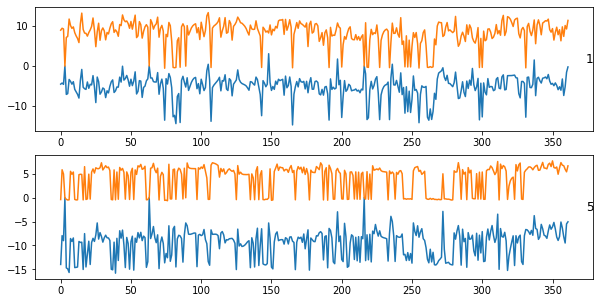

In [9]:
columns = [1, 5]
plt.figure(figsize=(10, 5))
for i, column in enumerate(columns):
    plt.subplot(len(columns), 1, i+1)
    plt.plot(datasets[in_sname].iloc[:, column])
    plt.plot(datasets[out_sname].iloc[:, column])
    # plt.plot(dataset_original.iloc[:, column])
    plt.title(column, y=0.5, loc='right')
plt.show()

## Data Preparation

The first step is to prepare the dataset for ML predictions. This involves framing the dataset as a supervised learning problem and normalizing the input variables (already done above).

### Convert series to supervised learning

**Assumption**  
We believe that predicitions in subsequent time step depend on values from **the last `STEPS_IN` time steps only**. 

Therefore:  

Number of samples = `dataset.shape[0] // STEPS_IN` (we need to throw last couple of timesteps)  
Number of input timesteps = `STEPS_IN`  
Number of output timesteps = `STEPS_OUT`  
Number of input features = `dataset.shape[1]`  
Number of output features = `dataset.shape[1]`

In [10]:
STEPS_IN = 2
STEPS_OUT = 1

In [11]:
reframed = {}
for sname in snames:
    reframed[sname] = series_to_supervised(datasets[sname].values, STEPS_IN, STEPS_OUT)

In [12]:
datasets[in_sname].shape, reframed[in_sname].shape

((362, 277), (360, 831))

In [13]:
datasets[out_sname].shape, reframed[out_sname].shape

((362, 277), (360, 831))

In [14]:
reframed[in_sname]

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var268(t),var269(t),var270(t),var271(t),var272(t),var273(t),var274(t),var275(t),var276(t),var277(t)
2,-7.991377,-4.567903,-4.643882,-7.181833,-13.985339,-13.985339,-7.181833,-6.083961,-13.985339,-13.985339,...,-14.305869,-14.305869,-14.305869,-14.305869,-14.305869,-14.305869,-14.305869,-14.305869,-14.305869,-14.305869
3,-7.624795,-4.288878,-4.490666,-5.428839,-14.177303,-7.960697,-5.908315,-5.477622,-14.177303,-14.177303,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-14.305869,-4.625462,-4.864337,-6.203888,-14.305869,-9.002564,-7.060927,-5.693184,-14.305869,-8.598758,...,-14.703773,-14.703773,-14.703773,-14.703773,-14.703773,-14.703773,-14.703773,-14.703773,-14.703773,-14.703773
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-14.895586,-14.895586,-14.895586,-14.895586,-14.895586,-14.895586,-14.895586,-14.895586,-14.895586,-14.895586
6,-10.088652,-7.153637,-6.514806,-6.055376,-14.703773,-14.703773,-9.400468,-7.389886,-14.703773,-14.703773,...,-15.661237,-15.661237,-15.661237,-15.661237,-15.661237,-15.661237,-15.661237,-15.661237,-15.661237,-15.661237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-14.956704,-5.233480,-7.215605,-3.718202,-14.956704,-8.153198,-6.192494,-8.047949,-7.785815,-8.962742,...,-13.656516,-13.656516,-13.656516,-13.656516,-13.656516,-13.656516,-13.656516,-13.656516,-13.656516,-13.656516
358,-13.008973,-6.100218,-6.792367,-2.996586,-13.008973,-5.107596,-3.721579,-4.596918,-6.610378,-6.610378,...,-15.286100,-15.286100,-15.286100,-15.286100,-15.286100,-15.286100,-15.286100,-15.286100,-15.286100,-15.286100
359,-13.656516,-3.267490,-4.020843,-2.234599,-13.656516,-6.342629,-3.830936,-5.025816,-7.949406,-6.485628,...,-15.894640,-15.894640,-15.894640,-15.894640,-15.894640,-15.894640,-15.894640,-15.894640,-15.894640,-15.894640
360,-9.292139,-7.422449,-5.278208,-5.876827,-15.286100,-8.195191,-7.735965,-6.896513,-8.482595,-8.600239,...,-11.203693,-11.203693,-11.203693,-11.203693,-11.203693,-11.203693,-11.203693,-11.203693,-11.203693,-11.203693


### Split data into train and test sets

In [15]:
TRAIN_TEST_SPLIT = 0.8
OVERLAP = True
SHUFFLE = False 

In [16]:
assert SHUFFLE == False  # TODO: pipeline doesn't work for `SHUFFLE = True` !!!

In [17]:
# train_X, train_y, test_X, test_y = {}, {}, {}, {}
# train_indices_y, test_indices_y = {}, {}
# for sname in snames:
#     train_X[sname], train_y[sname], test_X[sname], test_y[sname], \
#     train_indices_y[sname], test_indices_y[sname] = split_reframed(reframed[sname], len(datasets[sname].columns), TRAIN_TEST_SPLIT, 
#                                                      STEPS_IN, overlap=OVERLAP, shuffle=SHUFFLE, return_indices=True)

In [18]:
train_X, _, test_X, _ , _, _ = split_reframed(reframed[in_sname], len(datasets[in_sname].columns), TRAIN_TEST_SPLIT, 
                                              STEPS_IN, overlap=OVERLAP, shuffle=SHUFFLE, return_indices=True)

In [19]:
_, train_y, _, test_y, train_indices_y, test_indices_y = split_reframed(reframed[out_sname], len(datasets[out_sname].columns), 
                                              TRAIN_TEST_SPLIT, STEPS_IN, overlap=OVERLAP, shuffle=SHUFFLE, return_indices=True)

We should care only about:  
- `train_X[in_sname]`
- `test_X[in_sname]`
- `train_y[out_sname]`
- `test_y[out_sname]`

If the dataset is small, we could replicate the data by performing moving slicies (e.g. using `np.vstack()` see [here](https://stackoverflow.com/questions/15722324/sliding-window-of-m-by-n-shape-numpy-ndarray)).

Doing so, in our example we could get large input dataset.

---
## ALL ABOVE IS THE SAME FOR BOTH KERAS AND PYTORCH

---

## Define models

### Sequential
- We will define `in_features` independent multi-headed MLP with `in_steps` neurons in the first hidden layer, concatenate them and return `out_features` predictions.
- The input shape will be `in_steps` time steps with `in_features` features.
- We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

### Supervised
- We will define one-headed MLP with `in_steps x in_features` inputs and one hidden layer with `out_features` predictions.
- Therefore, it is purely a supervised model.
- We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

In [20]:
in_steps = train_X.shape[1]
in_features = train_X.shape[2]
out_features = train_y.shape[1]

In [21]:
assert in_steps == STEPS_IN
assert in_features == datasets[in_sname].shape[1]
assert out_features == datasets[out_sname].shape[1] * STEPS_OUT

In [22]:
train_X_seq, test_X_seq = prepare_sequential_data(train_X, test_X, in_features)
train_X_super, test_X_super = prepare_supervised_data(train_X, test_X, order='F')

#### Differencing (demo #2) (suitable for `in_steps = 2`)

In [23]:
# Differencing for supervised input
# each row corresponds to one timestep
# each column corresponds to one bacterium
# train_X_super_diff = train_X_super[:,in_features:] - train_X_super[:,:in_features]

In [24]:
# Differencing for sequential input
# for each element of the list (bacterium)
# each cell correspond to one timestep 
# train_X_seq_diff = train_X_seq[0][:,1] - train_X_seq[0][:,0]

### Declare parameters

#### If the data includes negative values, use linear activation in the last layer 

In [25]:
pred_activation = 'linear' if train_X.min() < 0 else 'relu'

In [26]:
kwargs_super = {'pred_activation': pred_activation, 'use_bias': True, 'L1': 0.0001, 'L2': 0.0001}
kwargs_seq = {'pred_activation': pred_activation, 'input_activation': 'relu', 
'use_input_bias': True, 'use_pred_bias': True, 'input_L1': 0.001, 'input_L2': 0.001, 'pred_L1': 0.0001, 'pred_L2': 0.0001}

### Standard MLP

In [27]:
# model_supervised = supervised_mlp(in_steps, in_features, out_features, **kwargs_super)
# model_sequential = sequential_mlp(in_steps, in_features, out_features,  **kwargs_seq)
# # or using subclass API
# # model_supervised = SupervisedMLP(in_steps, in_features, out_features, **kwargs_super)
# # model_supervised.compile(optimizer='adam', loss='mae')
# # model_sequential = SequentialMLP(in_steps, in_features, out_features, **kwargs_seq)
# # model_sequential.compile(optimizer='adam', loss='mae')

### With attention
#### Doesn't work in the current version i.e. attention context is not fully utilized in the training process...

In [28]:
# model_supervised = supervised_attention_mlp(in_steps, in_features, out_features, **kwargs_super)
# model_supervised.summary()
## Or:
# model_supervised = SupervisedAttentionMLP(in_steps, in_features, out_features, **kwargs_super)
# model_supervised.compile(optimizer='adam', loss='mae')

### With differencing

In [29]:
model_supervised = SupervisedDiffMLP(in_steps, in_features, out_features, **kwargs_super)
model_supervised.compile(optimizer='adam', loss='mae')
model_sequential = SequentialDiffMLP(in_steps, in_features, out_features, **kwargs_seq)
model_sequential.compile(optimizer='adam', loss='mae')

2022-09-29 09:52:04.322731: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 09:52:04.324500: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Fit models

2022-09-29 09:52:04.545820: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


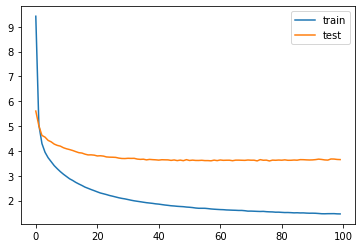

In [30]:
history = model_supervised.fit(train_X_super, train_y, epochs=100, batch_size=16, 
                    validation_data=(test_X_super, test_y), verbose=0, shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

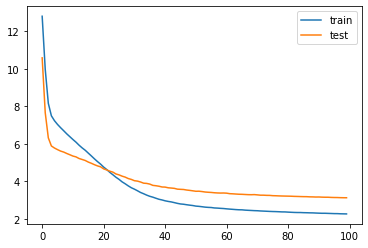

In [31]:
history = model_sequential.fit(train_X_seq, train_y, epochs=100, batch_size=16, 
                    validation_data=(test_X_seq, test_y), verbose=0, shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Evaluate models

- Evaluation doesn't work for `STEPS_OUT > 1`  
- Naive predictor doesn't work for `STEPS_OUT > 1`

But, both issues can be easily fixed (if needed).

### Naive predictions

Note that we can't use naive predictiors here - preprocessing transformer couldn't make an inverse transform in such case

In [32]:
columns_dict = dict(zip(datasets[out_sname], range(0, datasets[out_sname].shape[1])))
train_ynaive = datasets[out_sname].loc[train_indices_y - 1].rename(columns=columns_dict).set_index(train_indices_y)
test_ynaive = datasets[out_sname].loc[test_indices_y - 1].rename(columns=columns_dict).set_index(test_indices_y)

### Models' predictions

In [33]:
train_yhat_super = model_supervised.predict(train_X_super)
test_yhat_super = model_supervised.predict(test_X_super)
train_yhat_seq = model_sequential.predict(train_X_seq)
test_yhat_seq = model_sequential.predict(test_X_seq)

### Scores

In [34]:
# NOTE: this is dangerous! Please use with caution!
warnings.filterwarnings('ignore')

In [35]:
scores_train_naive = calculate_measures(train_y, train_ynaive)
scores_test_naive = calculate_measures(test_y, test_ynaive)
scores_train_super = calculate_measures(train_y, train_yhat_super)
scores_test_super = calculate_measures(test_y, test_yhat_super)
scores_train_seq = calculate_measures(train_y, train_yhat_seq)
scores_test_seq = calculate_measures(test_y, test_yhat_seq)

In [36]:
"Super, train:", scores_train_super, "Super, train (naive):", scores_train_naive

('Super, train:',
 {'f1score': (0.7975479251498813, 0.1303757437623316),
  'spearman': (0.5812099599136684, 0.16540880744924397, 0),
  'nrmse': (0.18867385351719249, 0.03658129823545968, 0),
  'inter': (0.16607360613915587, 0.12238208888239639),
  'intra': 0.4020100841762117},
 'Super, train (naive):',
 {'f1score': (0.7841043038701423, 0.15926293563758387),
  'spearman': (0.4926434436978595, 0.16250822724434213, 0),
  'nrmse': (0.2806810670720942, 0.07903306752996823, 0),
  'inter': (0.22465854231910845, 0.16244200605081013),
  'intra': 0.6365923520350977})

In [37]:
"Super, test:", scores_test_super, "Super, test (naive):", scores_test_naive

('Super, test:',
 {'f1score': (0.7054556397670068, 0.060585046001436),
  'spearman': (0.13525879408127053, 0.09962213750898269, 0),
  'nrmse': (0.7255568512237978, 1.0423944625527073, 0),
  'inter': (0.4271446134837886, 0.06129661283305469),
  'intra': 0.5494735899176636},
 'Super, test (naive):',
 {'f1score': (0.8195733199724751, 0.0680241746614323),
  'spearman': (0.3833088039139342, 0.16866908486664908, 0),
  'nrmse': (0.31214710131232415, 0.10623678802434028, 0),
  'inter': (0.19344316759027672, 0.07138127750040693),
  'intra': 0.5109392782510668})

In [38]:
"Seq, train:", scores_train_seq, "Seq, train (naive):", scores_train_naive

('Seq, train:',
 {'f1score': (0.8164331065135765, 0.14081364802946653),
  'spearman': (0.569846022319484, 0.1528878705576977, 0),
  'nrmse': (0.22272450912965333, 0.060640810427265, 0),
  'inter': (0.18445130960746256, 0.1211238243261418),
  'intra': 0.49102765311073987},
 'Seq, train (naive):',
 {'f1score': (0.7841043038701423, 0.15926293563758387),
  'spearman': (0.4926434436978595, 0.16250822724434213, 0),
  'nrmse': (0.2806810670720942, 0.07903306752996823, 0),
  'inter': (0.22465854231910845, 0.16244200605081013),
  'intra': 0.6365923520350977})

In [39]:
"Seq, test:", scores_test_seq, "Seq, test (naive):", scores_test_naive

('Seq, test:',
 {'f1score': (0.7577257933339838, 0.10025815238934184),
  'spearman': (0.23079722586545437, 0.14556492278234903, 0),
  'nrmse': (0.45568551967384, 0.4809095532181541, 0),
  'inter': (0.27144383774313807, 0.07565186485874936),
  'intra': 0.5847597478135447},
 'Seq, test (naive):',
 {'f1score': (0.8195733199724751, 0.0680241746614323),
  'spearman': (0.3833088039139342, 0.16866908486664908, 0),
  'nrmse': (0.31214710131232415, 0.10623678802434028, 0),
  'inter': (0.19344316759027672, 0.07138127750040693),
  'intra': 0.5109392782510668})

### Plots - supervised

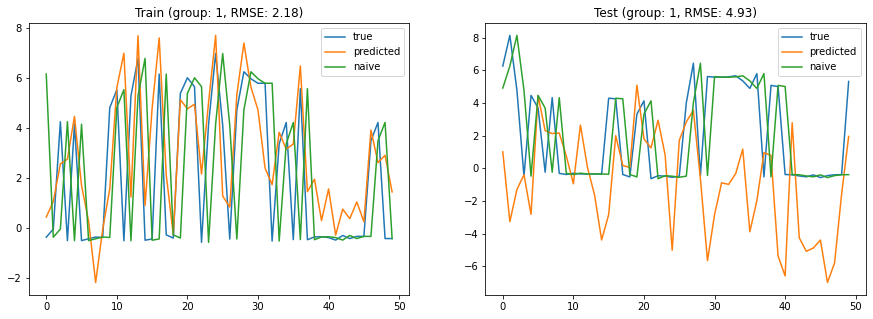

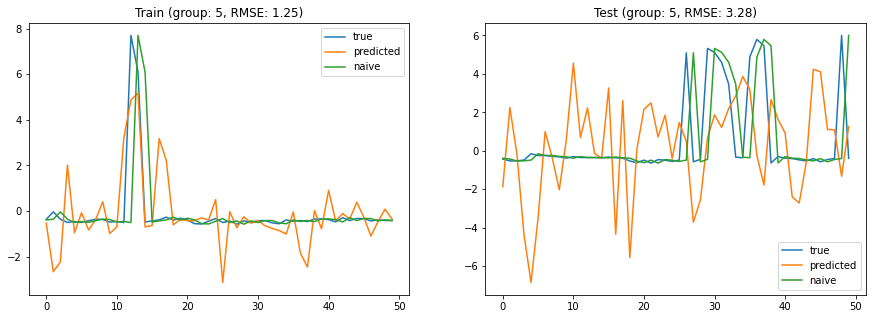

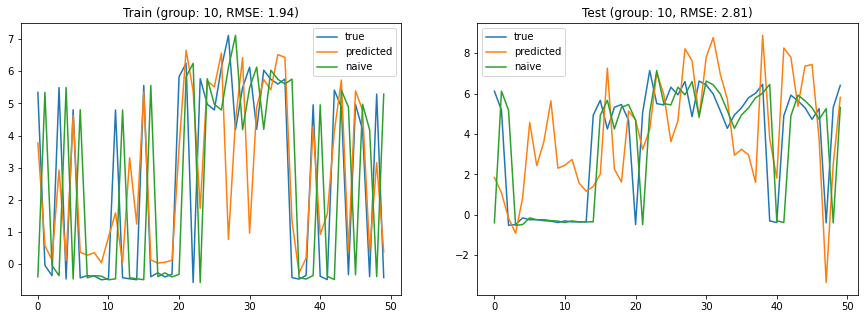

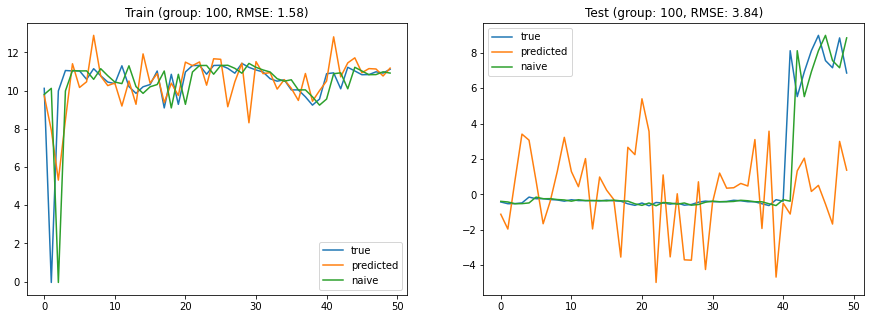

In [40]:
for group in [1, 5, 10, 100]:
    plot_series(pd.DataFrame(train_y).iloc[:50], pd.DataFrame(train_yhat_super).iloc[:50], train_ynaive.iloc[:50],
                pd.DataFrame(test_y).iloc[:50], pd.DataFrame(test_yhat_super).iloc[:50], test_ynaive.iloc[:50], 
                group)

### Plots - sequential

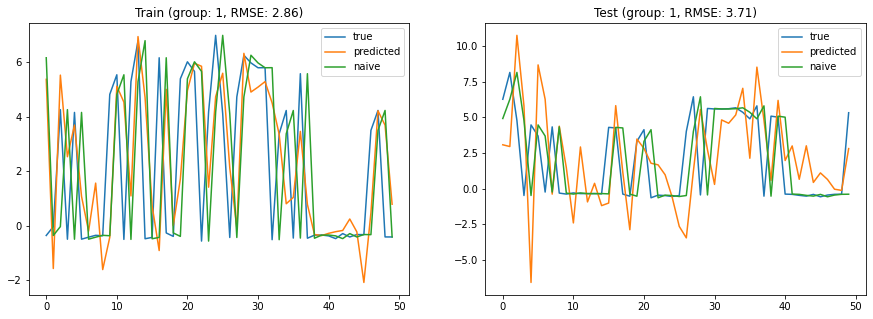

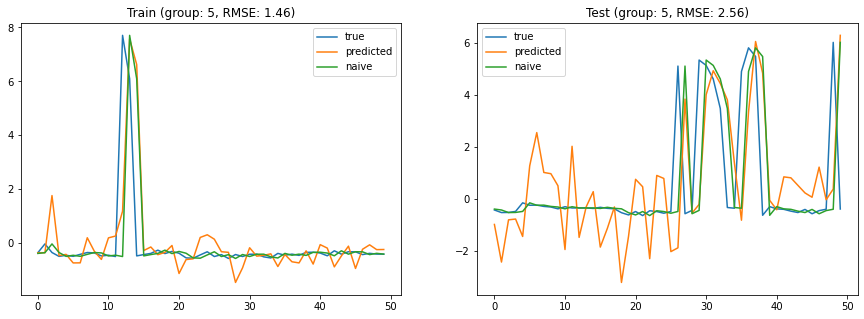

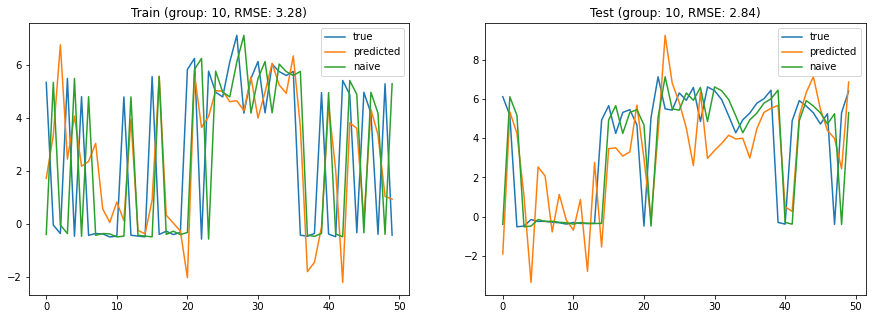

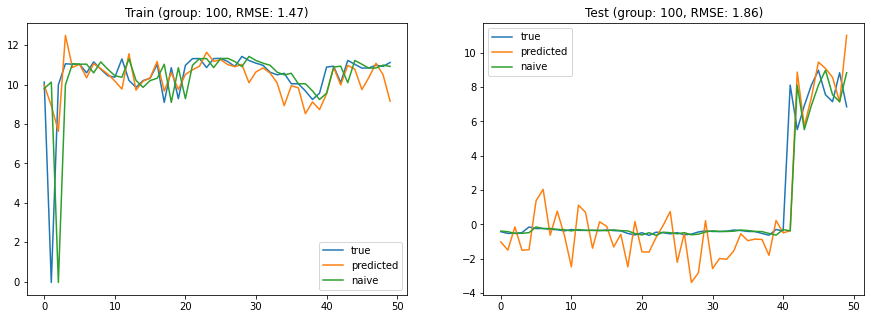

In [41]:
for group in [1, 5, 10, 100]:
    plot_series(pd.DataFrame(train_y).iloc[:50], pd.DataFrame(train_yhat_seq).iloc[:50], train_ynaive.iloc[:50],
                pd.DataFrame(test_y).iloc[:50], pd.DataFrame(test_yhat_seq).iloc[:50], test_ynaive.iloc[:50],
                group)

## Verify predictions with the ones generated in pipeline 

In [42]:
# names = ['supervised']
# pars = ["_".join([f"{k}={v}" for k, v in kwargs_super.items()][1:]),
#         "_".join([f"{k}={v}" for k, v in kwargs_seq.items()][2:])]

# if not SHUFFLE:
#     for i in range(len(names)):
#         path = Path(MODULE_PATH) / "pipelines" / "dataset_specific" / "results" / "baseline_diff" /\
#         f"mlp-diff_{names[i]}_id_{dname}_{filtername}_{sname}_overlap={OVERLAP}_shuffle=False_{pars[i]}"
#         train_val_pred = np.load(path / "train_val_predictions.npz")
#         # grand true
#         assert (train_val_pred['counts_val_y'] == test_inv_y.values).all()
#         assert (train_val_pred['counts_train_y'] == train_inv_y.values).all()
#         # naive
#         assert (train_val_pred['counts_val_ynaive'] == test_inv_ynaive.values).all()
#         assert (train_val_pred['counts_train_ynaive'] == train_inv_ynaive.values).all()
#         # measures
#         scores_train_counts = json.load(open(path / 'scores' / f'counts_train_ynaive.json', 'r'))
#         scores_val_counts = json.load(open(path / 'scores' / f'counts_val_ynaive.json', 'r'))
#         scores_train_trans = json.load(open(path / 'scores' / f'trans_train_ynaive.json', 'r'))
#         scores_val_trans = json.load(open(path / 'scores' / f'trans_val_ynaive.json', 'r'))
#         scores_train_counts_nb = calculate_measures(train_inv_ynaive, train_inv_y)
#         scores_val_counts_nb = calculate_measures(test_inv_ynaive, test_inv_y)
#         scores_train_trans_nb = calculate_measures(train_ynaive, train_y)
#         scores_val_trans_nb = calculate_measures(test_ynaive, test_y)
#         assert scores_train_counts.keys() == scores_val_counts.keys() == scores_train_trans.keys() == scores_val_trans.keys() == \
#         scores_train_counts_nb.keys() == scores_val_counts_nb.keys() == scores_train_trans_nb.keys() == scores_val_trans_nb.keys() == \
#         {'f1score', 'spearman', 'nrmse', 'inter', 'intra'}
#         for k in ['f1score', 'spearman', 'nrmse', 'inter']:
#             scores_train_counts[k] == list(scores_train_counts_nb[k])
#             scores_val_counts[k] == list(scores_val_counts_nb[k])
#             scores_train_trans[k] == list(scores_train_trans_nb[k])
#             scores_val_trans[k] == list(scores_val_trans_nb[k])
#         scores_train_counts['inter'] == scores_train_counts_nb['inter']
#         scores_val_counts['inter'] == scores_val_counts_nb['inter']
#         scores_train_trans['inter'] == scores_train_trans_nb['inter']
#         scores_val_trans['inter'] == scores_val_trans_nb['inter']